In [34]:
!pip install pygad

In [35]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import pad
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import pygad
from pygad import torchga

In [36]:
def matrix_decomp(x: torch.Tensor, n: int, sr: int):

    if x.dim() == 2:
        x = x[:,0]

    x_i = torch.full((n*sr,), float('nan'), dtype=torch.float32)
    pos = torch.arange(0, n)*sr
    x_i[pos] = x
    ones = torch.ones(x_i.shape[0], dtype=torch.float32)
    # Create 1.T
    ones = ones.unsqueeze(0)
    x_i = x_i.unsqueeze(1)
    X = torch.mm(x_i, ones)
    I = torch.eye(n*sr)
    I[I == 0] = float('nan')
    X = X*I
    return X

def shift(x: torch.Tensor, k=1):
    ''' shift the arrays'''
    if k > 0:
        y = torch.cat([torch.full((k,), float('nan')), x])
        y = y[:len(x)]
    elif k < 0:
        k = abs(k)
        y = torch.cat([x, torch.full((k,), float('nan'))])
        y = y[k:]
    else:
        y = x
    return y

def X_shift(X: torch.Tensor, sr: int, p: torch.Tensor):
    # First enlarge the array to include the largest positive time shift
    if torch.max(p) > 0:
        X_out = F.pad(X.clone().detach(), (0, X.shape[0]), mode='constant', value=float('nan'))
    else:
        X_out = X.clone().detach()

    # Shift the values
    for i in range(1, int(X.shape[0]/sr)):
        x_r = X_out[i*sr, :]
        x_shift = shift(x_r, int(p[i].item()))
        X_out[i*sr, :] = x_shift

    return X_out

def fill_nan_with_last_value(x):
    mask = torch.isnan(x)

    last = x[0].item()
    for i in range(1, x.shape[0]):
        if mask[i].item():
            x[i] = last
        elif mask[i].item() is False:
            last = x[i].item()
    return x


In [130]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import numpy as np


class ShiftNetwork(nn.Module):
    def __init__(self, n, hidden_size, t, n_knots):
        super(ShiftNetwork, self).__init__()
        self.n = n
        self.hidden_size = hidden_size
        self.n_knots = n_knots
        self.t = t
        self.B = nn.Parameter(torch.zeros(n_knots))

        self.fc1 = nn.Linear(n, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

        self.sr = 10

        self.sigma = nn.Parameter(torch.ones(1))
        self.sigma_t = nn.Parameter(torch.ones(1), requires_grad=True)

    def basis_matrix(self):
        x = torch.arange(1, self.t + 1)  # Sample x values
        self.k_values = torch.arange(0, self.n_knots) * (self.t / self.n_knots)  # Values of k
        self.rw_interval = torch.diff(self.k_values)[0].item()
        X = self.create_basis(x, self.k_values)
        return X

    def piecewise_linear(self, x, k):
        y = x - k
        y[x < 0] = 0
        y[x < k] = 0
        return y

    def create_basis(self, x, k):
      num_x = len(x)
      num_k = len(k)
      b = torch.zeros((num_x, num_k))
      for i in range(num_k):
          b_i = self.piecewise_linear(x, k[i])
          b[:, i] = b_i
      return b

    def shift_rows(self, X, p):
        # Get the dimensions of the input matrix
        num_rows, num_cols = X.size()

        # Create an empty tensor of the same shape as the input matrix
        shifted_X = torch.torch.full((X.shape[0],X.shape[1]), float('nan'))

        # Iterate over each row of the input matrix
        for i in range(0, (len(p)-1)):
            # Get the shift value for the current row
            shift_amount = int(p[i].item())  # Convert tensor to scalar

            # Perform the row shifting operation
            shifted_X[i*self.sr, :] = torch.roll(X[i*self.sr, :], shifts=shift_amount, dims=0)

        return shifted_X

    def nan_mean(self, input):
        # Create a mask for NaN values
        mask = torch.isnan(input)

        # Replace NaN values with zeros
        input_zeros = torch.where(mask, torch.zeros_like(input), input)

        # Compute the sum and count of non-NaN values along each column
        col_sum = torch.sum(input_zeros, dim=0)
        col_count = torch.sum(~mask, dim=0, dtype=torch.float32)

        # Compute the column-wise mean, ignoring NaN values
        output = torch.where(col_count > 0, col_sum / col_count, torch.tensor(float('nan')))

        return output

    def fill_nan_with_last_value(self, x):
        mask = torch.isnan(x)

        last = x[0].item()
        for i in range(1, x.shape[0]):
            if mask[i].item():
                x[i] = last
            elif mask[i].item() is False:
                last = x[i].item()
        return x

    def conditional_posterior(self, d, u, sd, n_steps):
        ''' Posterior Conditional conditional on f(X | Xn = d) Distribution
        Multivariate gaussian distribution'''
        u = (d / n_steps)
        sd = torch.sqrt((sd ** 2) * (n_steps - 1) / n_steps)
        return u, sd

    def px_z(self, u1, u2, sd1, sd2):
        ''' Find the pdf of Z ~N(u2, sd2**2), given the parameters of X ~ (u1, sd1**2) '''

        # Define the constants
        alpha = torch.sqrt(1 / (2 * sd2**2) + 1 / (2 * sd1**2))
        alpha_beta = u2 / (2 * sd2**2) + u1 / (2 * sd1**2)
        gamma = (u2**2) / (2 * sd2**2) + (u1**2) / (2 * sd1**2)
        beta = alpha_beta / alpha

        # Define the components
        p1 = 1 / (2 * sd1 * sd2 * alpha * torch.sqrt(torch.tensor(np.pi)))
        p2 = torch.exp(-gamma + beta**2)

        return p1 * p2

    def reverse_softplus(self, x):
        if x > -10:
          return -torch.log(1 + torch.exp(-x))
        else:
          return x

    def expected_likelihood(self, d, u, sd, n_steps):
        ''' Analytical Solution to the Expected Likelihood
        Given a random walk what is the expected likelihood
        of the walk, given that it took n_steps and moved a vertical distance d'''
        post_u, post_sd = self.conditional_posterior(d, u, sd, n_steps)
        el = torch.log(self.px_z(u1=0, u2=post_u, sd1=sd, sd2=post_sd))
        # Apply a reversed softplus so that the values are bounded to P=1
        el = self.reverse_softplus(el * n_steps)
        return el

    def terror_likelihood(self, k_values, sd, RW_width, p):
            ''' Calculate the likelihood across on the time axis
            The returned value comprises the expected likelihood, calculated
            between each of the k knot values'''
            total_likelihood = 0
            k_values = torch.cat([k_values, torch.tensor(len(p)).unsqueeze(0) - 1])
            for i in range(1, len(k_values)):
              x1 = k_values[i-1]
              x2 = k_values[i]

              y1 = p[x1.to(torch.int)]
              y2 = p[x2.to(torch.int)]

              d = y2 - y1

              el = self.expected_likelihood(d, 0, sd, RW_width)
              total_likelihood = total_likelihood + el
            return total_likelihood

    def forward(self, X, basis_X):

        p = torch.matmul(basis_X, self.B)

        x_shift = self.shift_rows(X, p)
        x_shift  = self.nan_mean(x_shift)
        x_shift = self.fill_nan_with_last_value(x_shift.squeeze(0))
        x_shift[0] = X[0,0]

        x_shift = x_shift[::self.sr]
        x_shift = x_shift[:len(p)]
        x_shift = x_shift.unsqueeze(1)

        h1 = self.relu(self.fc1(x_shift))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        y = self.fc4(h3)
        return y.squeeze(1), p

    def predict_realisations(self,X,n):
        realisations = []
        for i in range(n):
          y = self.predict(X, True).detach().numpy()
          realisations.append(y)
        return realisations

    def predict(self, X, rw_realisation=False):
        if rw_realisation is False:
          # Predict without any time shifting
          p = torch.matmul(basis_X, torch.tensor(torch.zeros(self.B.shape[0])))
        else:
          rw = np.cumsum(np.random.normal(0, np.exp(self.sigma_t.detach().numpy())*self.sr,size=X.shape[0]), axis=0)
          p = rw[::model.sr]

        x_shift = self.shift_rows(X, p)
        x_shift  = self.nan_mean(x_shift)
        x_shift = self.fill_nan_with_last_value(x_shift.squeeze(0))
        x_shift[0] = X[0,0]

        x_shift = x_shift[::self.sr]
        x_shift = x_shift[:len(p)]
        x_shift = x_shift.unsqueeze(1)

        h1 = self.relu(self.fc1(x_shift))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        y = self.fc4(h3)
        return y.squeeze(1)

    def log_likelihood(self, y_pred, y, p):

        # Compute log likelihood of data given model parameters
        sigma = torch.exp(self.sigma)
        sigma_t = torch.exp(self.sigma_t)
        dist = Normal(loc=0, scale=sigma)
        ll = dist.log_prob(y_pred-y).sum()
        #print(f"error likelihood:{ll}")

        #print(sigma_t)
        tl = self.terror_likelihood(self.k_values, sigma_t, self.rw_interval, p)
        #print(f"t-error:{tl}")
        # Maximize therefore multiply by -1 (positive for pygad)
        return (ll + tl)

In [38]:
def generate_example_waves(n):
    np.random.seed(12)
    x = np.arange(1,n+1)/100
    x = 2*np.pi*x
    y1 = np.sin(x)
    y2 = np.sin(x) + np.random.normal(0, 0.5, size=n)
    return x, y1, y2


def generate_sample_perturbations(scale, n, type="gaussian", truncate=False, sr=10):
    perturbations = (np.random.normal(loc=0, scale=(scale - 1), size=n))
    perturbations = perturbations.astype("int")
    if truncate is True:
        perturbations[perturbations <= -1*sr] = -1*sr
    p_cum = np.cumsum(perturbations)
    return perturbations, p_cum

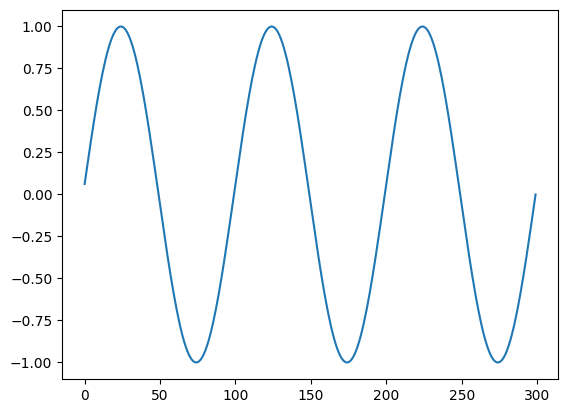

In [39]:
# Create sample waves
n=300
sr=10
z, x, y1 = generate_example_waves(n)
plt.plot(x)

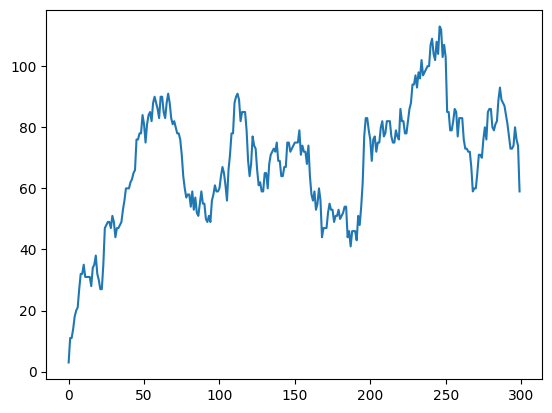

In [40]:
# Create perturbation profile
p_step, p = generate_sample_perturbations(6, n, truncate=False, sr=sr)
plt.plot(p)

In [99]:
# Example usage
x = torch.tensor(x, dtype=torch.float32)
#print(x)
X = matrix_decomp(x, n, sr)
print(X.grad_fn)

X_s = X_shift(X, sr, torch.tensor(p))
print(X_s.grad_fn)

x_s = torch.nanmedian(X_s, dim=0).values
x_out = fill_nan_with_last_value(x_s)

# Downsample
y = x_out[::sr]
print(x_out.grad_fn)
y = y[:len(x)]
print(y.shape)

<ipython-input-99-efcedf45c796>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
<ipython-input-99-efcedf45c796>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_s = X_shift(X, sr, torch.tensor(p))


None
None
None
torch.Size([300])


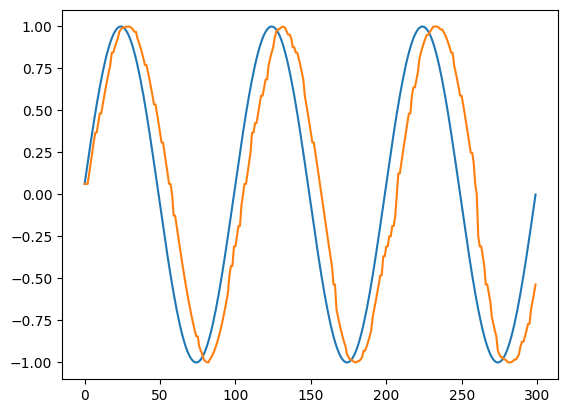

In [42]:
plt.plot(x)
plt.plot(y)
x = x.unsqueeze(1)

In [131]:
x = x.to(torch.float32)
y = y.to(torch.float32)

# Initialise the perturbation network
model = ShiftNetwork(n=1, hidden_size=5, t=n, n_knots=5)
basis_X = model.basis_matrix()
optimizer = optim.Adam(model.parameters(), lr=0.01)

X = matrix_decomp(x, x.shape[0], sr)

# Use standarised time range as input p
p = torch.tensor(np.arange(0,len(p))/len(p),dtype=torch.float32).unsqueeze(0).T

# Double the size along the second axis
X= torch.cat((X, torch.full((3000, 6000), float('nan'))), dim=1)


## Genetic Algo Training

In [44]:
def fitness_func(ga_instance, solution, sol_idx):
    global X, basis_X, y, torch_ga, model
    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)


    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    y_pred, p = model(X, basis_X)

    ll = model.log_likelihood(y_pred, y, p)
    ll = ll.detach().numpy()

    solution_fitness = ll#1.0 / ll

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))


In [48]:
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=50)

In [49]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
num_generations = 100 # Number of generations.
num_parents_mating = 2 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights.

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       sol_per_pop=50,
                       num_genes = len(initial_population),
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

Generation = 1
Fitness    = [-989.4312]
Generation = 2
Fitness    = [-898.92554]
Generation = 3
Fitness    = [-758.0569]
Generation = 4
Fitness    = [-670.0887]
Generation = 5
Fitness    = [-637.3683]
Generation = 6
Fitness    = [-587.0595]
Generation = 7
Fitness    = [-553.4097]
Generation = 8
Fitness    = [-479.51904]
Generation = 9
Fitness    = [-432.11133]
Generation = 10
Fitness    = [-376.2359]
Generation = 11
Fitness    = [-290.23053]
Generation = 12
Fitness    = [-283.13632]
Generation = 13
Fitness    = [-230.0486]
Generation = 14
Fitness    = [-230.0486]
Generation = 15
Fitness    = [-230.0486]
Generation = 16
Fitness    = [-230.0486]
Generation = 17
Fitness    = [-209.57799]
Generation = 18
Fitness    = [-209.57799]
Generation = 19
Fitness    = [-206.69206]
Generation = 20
Fitness    = [-201.01929]
Generation = 21
Fitness    = [-137.21332]
Generation = 22
Fitness    = [-126.4047]
Generation = 23
Fitness    = [-105.398476]
Generation = 24
Fitness    = [-97.34833]
Generation = 

Fitness    = [-14.28511]


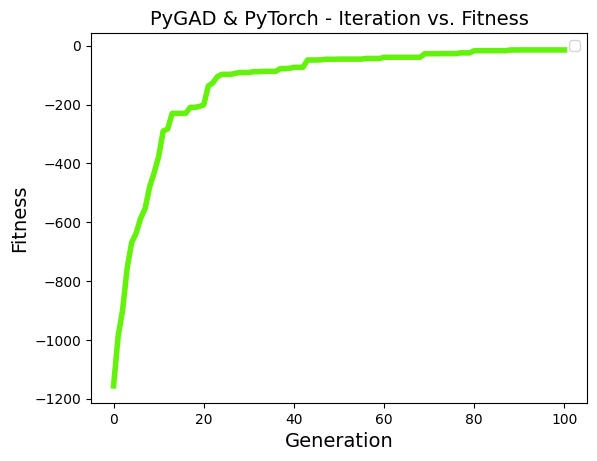

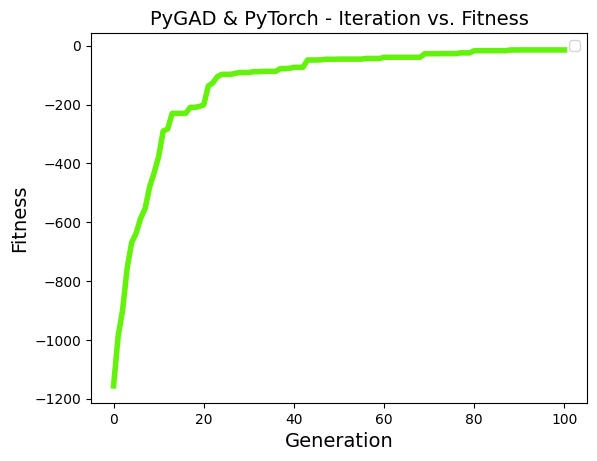

In [50]:
torch.set_grad_enabled(False)
# Start the genetic algorithm evolution.
ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

In [51]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
y_pred, p = model(X, basis_X)

Fitness value of the best solution = [-14.28511]
Index of the best solution : 0


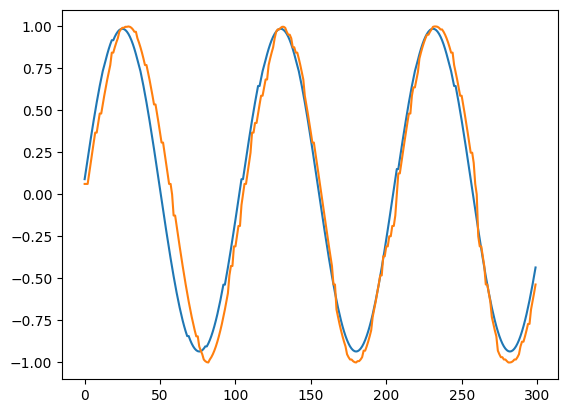

In [52]:
plt.plot(y_pred.detach().numpy())
plt.plot(y)
plt.show()

In [53]:
model.B

Parameter containing:
tensor([ 0.0524,  0.8685, -0.9746,  0.3184, -0.2310], requires_grad=True)

In [54]:
for name, param in model.named_parameters():
    if name == 'B' or name == 'sigma_t':
      print(f"Freezing:{name}")
      param.requires_grad = False

Freezing:B
Freezing:sigma_t


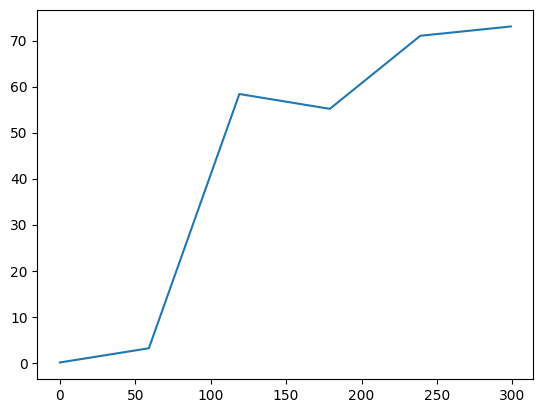

In [55]:
plt.plot(p.detach().numpy())

## Fine-tuning

0
B None
sigma None
sigma_t None
fc1.weight None
fc1.bias None
fc2.weight None
fc2.bias None
fc3.weight None
fc3.bias None
fc4.weight None
fc4.bias None


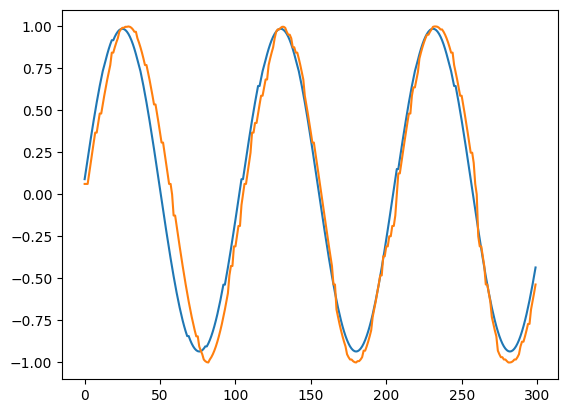

1
2
3
4
5
6
7
8
9
10
B None
sigma tensor([3.9470])
sigma_t None
fc1.weight tensor([[ 0.0000],
        [78.2869],
        [67.8007],
        [ 0.0000],
        [ 0.0000]])
fc1.bias tensor([   0.0000, -220.7932,  518.7575,    0.0000,    0.0000])
fc2.weight tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,   49.6061,   37.2076,    0.0000,    0.0000],
        [   0.0000,    0.0000,  137.7824,    0.0000,    0.0000],
        [   0.0000, -396.7334, -297.5739,    0.0000,    0.0000],
        [   0.0000, -291.6772, -218.7754,    0.0000,    0.0000]])
fc2.bias tensor([   0.0000,   45.0528,   84.4588, -360.3172, -264.9041])
fc3.weight tensor([[    0.0000, -2174.9355,   -10.5141,  -292.2051,  -929.1598],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000

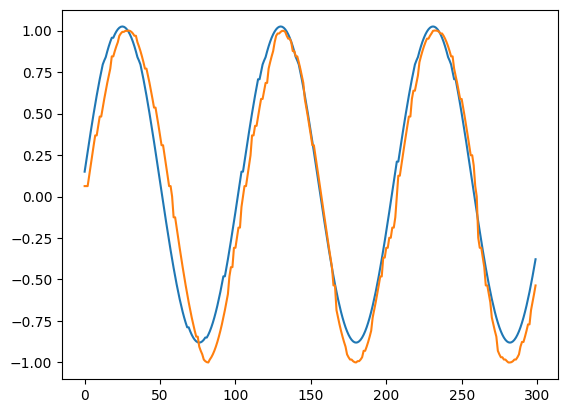

11
12
13
14
15
16
17
18
19
20
B None
sigma tensor([15.6242])
sigma_t None
fc1.weight tensor([[ 0.0000],
        [34.6675],
        [65.1982],
        [ 0.0000],
        [ 0.0000]])
fc1.bias tensor([   0.0000, -113.7070,  288.6700,    0.0000,    0.0000])
fc2.weight tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,   23.5599,   21.4143,    0.0000,    0.0000],
        [   0.0000,    0.0000,   86.4358,    0.0000,    0.0000],
        [   0.0000, -193.5322, -175.9076,    0.0000,    0.0000],
        [   0.0000, -142.5426, -129.5616,    0.0000,    0.0000]])
fc2.bias tensor([   0.0000,   23.8298,   53.0799, -195.7495, -144.1758])
fc3.weight tensor([[    0.0000, -1193.7001,    -6.0661,  -146.5648,  -475.8543],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000, 

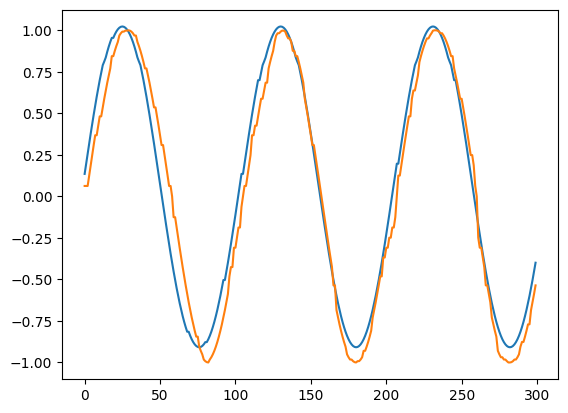

21
22
23
24
25
26
27
28
29
30
B None
sigma tensor([-3.2940])
sigma_t None
fc1.weight tensor([[  0.0000],
        [ 30.6420],
        [-13.0917],
        [  0.0000],
        [  0.0000]])
fc1.bias tensor([  0.0000, -71.4808, 136.2250,   0.0000,   0.0000])
fc2.weight tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,   16.2575,    8.9170,    0.0000,    0.0000],
        [   0.0000,    0.0000,   18.4467,    0.0000,    0.0000],
        [   0.0000, -135.8636,  -74.5197,    0.0000,    0.0000],
        [   0.0000, -100.1779,  -54.9465,    0.0000,    0.0000]])
fc2.bias tensor([   0.0000,   12.7748,   11.4842, -106.7588,  -78.7177])
fc3.weight tensor([[   0.0000, -622.0396,   -0.9504, -100.0206, -301.0417],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000]])

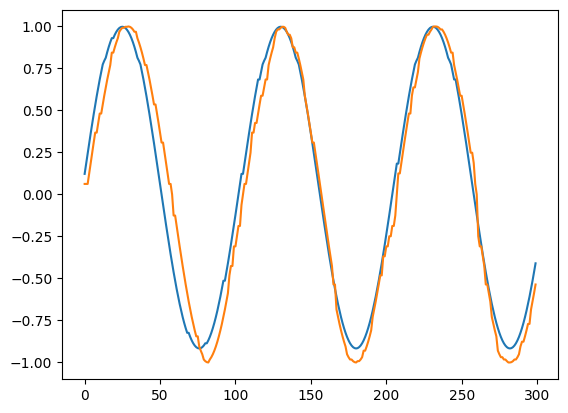

31
32
33
34
35
36
37
38
39
40
B None
sigma tensor([-9.2724])
sigma_t None
fc1.weight tensor([[ 0.0000],
        [23.2228],
        [ 0.9674],
        [ 0.0000],
        [ 0.0000]])
fc1.bias tensor([  0.0000, -51.3035, 111.4232,   0.0000,   0.0000])
fc2.weight tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,  11.8195,   7.1420,   0.0000,   0.0000],
        [  0.0000,   0.0000,  24.2140,   0.0000,   0.0000],
        [  0.0000, -99.4481, -60.0917,   0.0000,   0.0000],
        [  0.0000, -73.3561, -44.3255,   0.0000,   0.0000]])
fc2.bias tensor([  0.0000,   9.6994,  15.1745, -81.6097, -60.1979])
fc3.weight tensor([[   0.0000, -479.2117,   -1.1339,  -73.6926, -224.2385],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000]])
fc3.bias tensor([-88.2789,   0.000

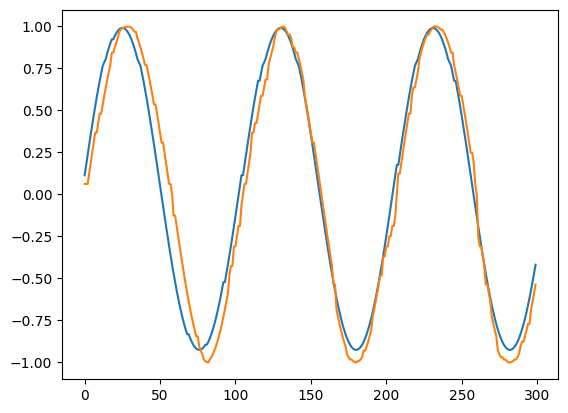

41
42
43
44
45
46
47
48
49
50
B None
sigma tensor([-0.5597])
sigma_t None
fc1.weight tensor([[ 0.0000],
        [16.1063],
        [16.1122],
        [ 0.0000],
        [ 0.0000]])
fc1.bias tensor([  0.0000, -23.0558,  78.3632,   0.0000,   0.0000])
fc2.weight tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   6.3806,   5.4881,   0.0000,   0.0000],
        [  0.0000,   0.0000,  23.9087,   0.0000,   0.0000],
        [  0.0000, -53.9565, -46.4090,   0.0000,   0.0000],
        [  0.0000, -39.8081, -34.2397,   0.0000,   0.0000]])
fc2.bias tensor([  0.0000,   6.2810,  14.9369, -53.1148, -39.1871])
fc3.weight tensor([[   0.0000, -321.1215,   -1.2163,  -41.2624, -131.5194],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000]])
fc3.bias tensor([-57.4414,   0.000

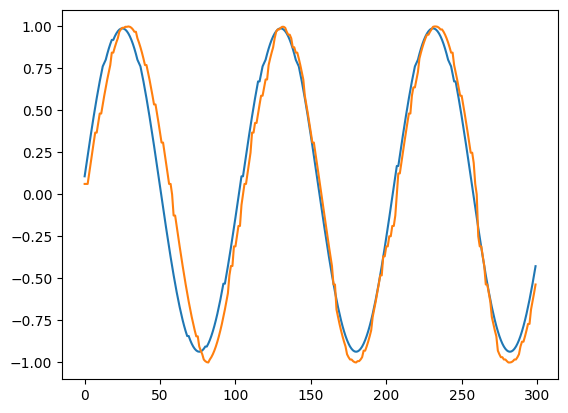

51
52
53
54
55
56
57
58
59
60
B None
sigma tensor([3.2427])
sigma_t None
fc1.weight tensor([[0.0000],
        [5.1219],
        [9.7531],
        [0.0000],
        [0.0000]])
fc1.bias tensor([ 0.0000, -0.9049, 23.1215,  0.0000,  0.0000])
fc2.weight tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   1.1186,   1.9704,   0.0000,   0.0000],
        [  0.0000,   0.0000,   7.6049,   0.0000,   0.0000],
        [  0.0000,  -9.5186, -16.7674,   0.0000,   0.0000],
        [  0.0000,  -7.0240, -12.3730,   0.0000,   0.0000]])
fc2.bias tensor([  0.0000,   1.7802,   4.9521, -15.1488, -11.1786])
fc3.weight tensor([[ 0.0000e+00, -9.6032e+01, -3.1214e-02, -8.4405e+00, -2.9863e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+0

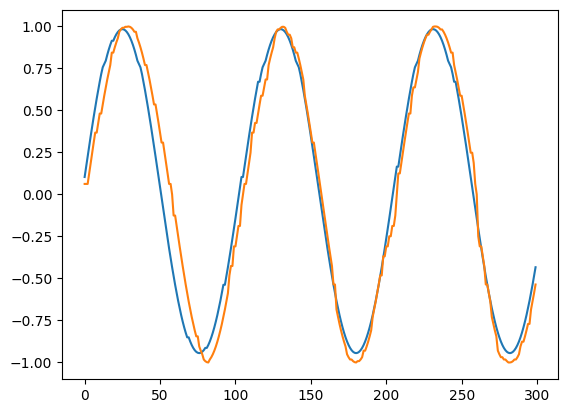

61
62
63
64
65
66
67
68
69
70
B None
sigma tensor([0.0732])
sigma_t None
fc1.weight tensor([[ 0.0000],
        [-1.2770],
        [-0.2548],
        [ 0.0000],
        [ 0.0000]])
fc1.bias tensor([  0.0000,  14.3321, -19.1785,   0.0000,   0.0000])
fc2.weight tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -2.2281, -0.9418,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -6.4741,  0.0000,  0.0000],
        [ 0.0000, 19.0976,  8.0727,  0.0000,  0.0000],
        [ 0.0000, 14.0947,  5.9579,  0.0000,  0.0000]])
fc2.bias tensor([ 0.0000, -1.5219, -3.6739, 13.0449,  9.6276])
fc3.weight tensor([[ 0.0000, 74.5947,  0.9612, 13.3566, 39.8636],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
fc3.bias tensor([14.1046,  0.0000,  0.0000,  0.0000,  0.0000])
fc4.weight tensor([[-71.4708,   0.0000,   0.0000,   

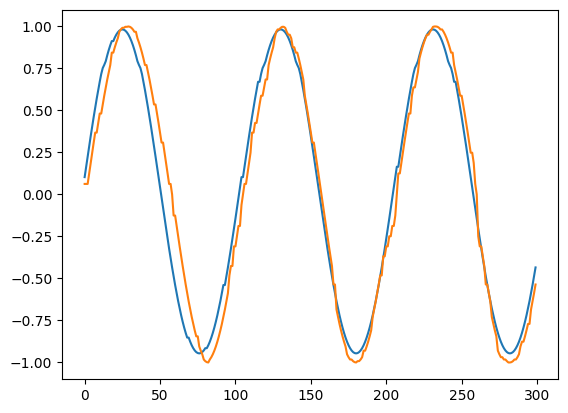

71
72
73
74
75
76
77
78
79
80
B None
sigma tensor([-1.0723])
sigma_t None
fc1.weight tensor([[ 0.0000],
        [ 0.8820],
        [-1.7040],
        [ 0.0000],
        [ 0.0000]])
fc1.bias tensor([  0.0000,   9.9960, -11.7330,   0.0000,   0.0000])
fc2.weight tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -1.1991, -0.6436,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -4.4715,  0.0000,  0.0000],
        [ 0.0000, 10.3247,  5.5421,  0.0000,  0.0000],
        [ 0.0000,  7.6201,  4.0903,  0.0000,  0.0000]])
fc2.bias tensor([ 0.0000, -0.9024, -2.4668,  7.7702,  5.7348])
fc3.weight tensor([[ 0.0000, 45.4085,  0.7913,  7.2883, 22.3403],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
fc3.bias tensor([8.4060, 0.0000, 0.0000, 0.0000, 0.0000])
fc4.weight tensor([[-38.9560,   0.0000,   0.0000,   0.00

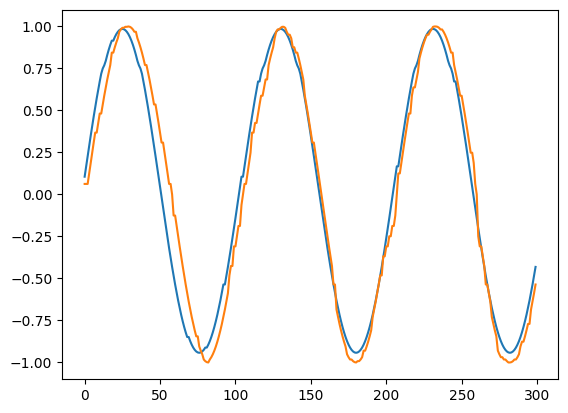

81
82
83
84
85
86
87
88
89
90
B None
sigma tensor([0.2191])
sigma_t None
fc1.weight tensor([[0.0000],
        [3.9962],
        [0.6642],
        [0.0000],
        [0.0000]])
fc1.bias tensor([0.0000, 0.2817, 8.8767, 0.0000, 0.0000])
fc2.weight tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7425,  0.6616,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4797,  0.0000,  0.0000],
        [ 0.0000, -6.4110, -5.7126,  0.0000,  0.0000],
        [ 0.0000, -4.7314, -4.2160,  0.0000,  0.0000]])
fc2.bias tensor([ 0.0000,  0.7673,  1.1534, -6.6253, -4.8896])
fc3.weight tensor([[  0.0000, -39.9149,   0.2941,  -5.1885, -16.1514],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])
fc3.bias tensor([-7.1717,  0.0000,  0.0000,  0.0000,  0.0000])
fc4.weight tensor([[29.3940,  0.0000,  0.0

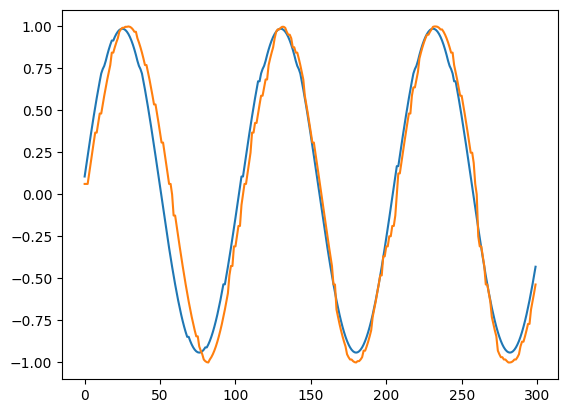

91
92
93
94
95
96
97
98
99


In [56]:
torch.set_grad_enabled(True)

# Use a very small learning rate
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model for 100 epochs
for epoch in range(100):
    # Backward pass

    print(epoch)

    # Forward pass 1
    #p_out = p_mod(basis_X)
    y_pred, p = model(X, basis_X)

    loss = -1*model.log_likelihood(y_pred, y, p)

    if epoch % 10 == 0:
      for name, param in model.named_parameters():
          print(name, param.grad)

      plt.plot(y_pred.detach().numpy())
      plt.plot(y)
      plt.show()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Plot Best Fit

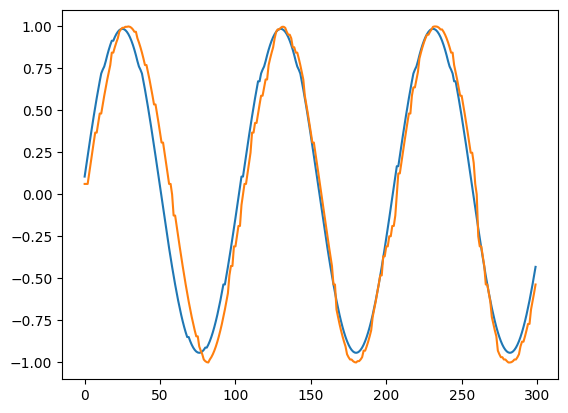

In [57]:
plt.plot(y_pred.detach().numpy())
plt.plot(y)
plt.show()


In [132]:
#Save the model parameters if necessary
#saved_model = model.state_dict()
#model.load_state_dict(saved_model)

<All keys matched successfully>

In [141]:
rw_predictions = model.predict_realisations(X, 400)


In [142]:
# Stack the paths into a single array and plot
all_paths = np.stack(rw_predictions)

In [143]:
# Calculate the quantiles
q10 = np.quantile(all_paths, axis=0, q=0.10)
q90 = np.quantile(all_paths, axis=0, q=0.90)
q50 = np.quantile(all_paths, axis=0, q=0.50)

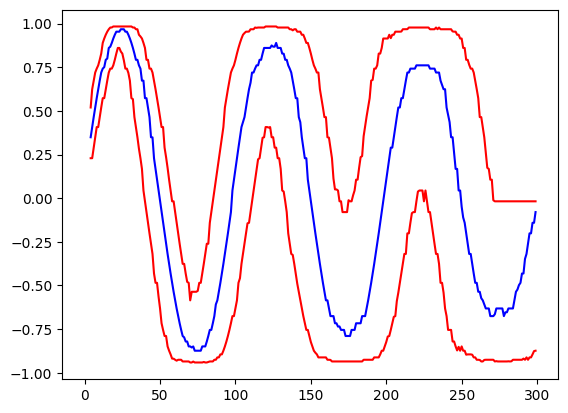

In [144]:
# Plot the quantiles
plt.plot(q50, color="blue")
plt.plot(q10, color="red")
plt.plot(q90, color="red")
plt.show()

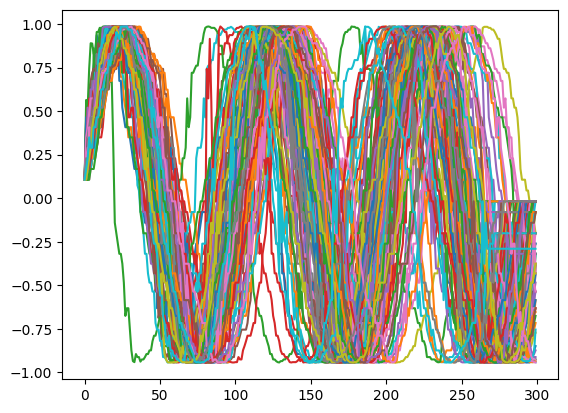

In [140]:
# Plot the raw paths
plt.plot(all_paths.T)